In [1]:
import cirq
import numpy as np
import matplotlib.pyplot as plt
from sympy import Matrix
import random


In [2]:
def generate_secret_string(n):
    """
    Generates a random secret string s of length n with at least one '1'.
    """
    while True:
        s = [random.randint(0, 1) for _ in range(n)]
        if any(s):
            return s


In [3]:
def create_simon_oracle(s: list[int]) -> cirq.Circuit:
    """
    Creates a Cirq circuit implementing the oracle for Simon's algorithm
    with the hidden bitstring s represented as a list of bits.

    Args:
        s (list[int]): The hidden bitstring for Simon's algorithm (e.g., [1, 0, 1]).

    Returns:
        cirq.Circuit: The quantum oracle circuit.
    """
    # Validation
    if not isinstance(s, list):
        raise TypeError("Hidden bitstring 's' must be provided as a list of bits (e.g., [1, 0, 1]).")
    if len(s) == 0:
        raise ValueError("Hidden bitstring 's' must contain at least one bit.")
    if any(bit not in (0, 1) for bit in s):
        raise ValueError("All elements in 's' must be either 0 or 1.")
    if all(bit == 0 for bit in s):
        raise ValueError("Hidden bitstring 's' must contain at least one '1'.")

    n = len(s)  # Number of qubits

    # Define qubits: first n for input x, next n for output y
    qubits_x = cirq.LineQubit.range(n)
    qubits_y = cirq.LineQubit.range(n, 2 * n)

    # Initialize the circuit
    circuit = cirq.Circuit()

    # Step 1: Apply CNOTs from each x[i] to y[i]
    for i in range(n):
        circuit.append(cirq.CNOT(qubits_x[i], qubits_y[i]),
                       strategy=cirq.InsertStrategy.NEW)

    # Step 2: Identify the first qubit in s that is '1'
    try:
        first_one_index = s.index(1)
    except ValueError:
        # This should not happen as we checked that at least one '1' exists
        raise ValueError("Hidden bitstring 's' must contain at least one '1'.")

    # Step 3: Apply additional CNOTs controlled by x[first_one_index] to y[i] where s[i] == 1
    for i, bit in enumerate(s):
        if bit == 1:
            circuit.append(cirq.CNOT(qubits_x[first_one_index], qubits_y[i]),
                           strategy=cirq.InsertStrategy.NEW)

    return circuit

In [4]:
def simons_algorithm_circuit(n, s):
    """
    Constructs Simon's Algorithm circuit for n qubits.

    Parameters:
    - n: Number of input qubits.
    - s: Secret string as a list of bits.

    Returns:
    - Cirq Circuit implementing Simon's Algorithm.
    """
    # Define qubits
    input_qubits = [cirq.LineQubit(i) for i in range(n)]
    output_qubits = [cirq.LineQubit(i + n) for i in range(n)]
    qubits = input_qubits + output_qubits

    # Create circuit
    circuit = cirq.Circuit()

    # Step 1: Apply Hadamard gates to input qubits to create superposition
    for q in input_qubits:
        circuit.append(cirq.H(q))

    # Step 2: Apply the oracle
    oracle_ops = create_simon_oracle(s)
    circuit.append(oracle_ops)

    # Step 3: Measure output qubits to collapse the state
    # This step is optional but helps in visualization
    for q in output_qubits:
        circuit.append(cirq.measure(q, key=f"m_{q}"))

    # Step 4: Apply Hadamard gates to input qubits
    for q in input_qubits:
        circuit.append(cirq.H(q))

    # Step 5: Measure input qubits
    for q in input_qubits:
        circuit.append(cirq.measure(q, key=f"m_{q}"))

    return circuit


In [5]:
def run_simulation(circuit, repetitions=2048, noise_level=0.0):
    """
    Runs the quantum circuit on a simulator.

    Parameters:
    - circuit: Cirq Circuit to execute.
    - repetitions: Number of simulation runs.
    - noise_level: Probability of error for depolarizing noise.

    Returns:
    - Result object from the simulation.
    """
    simulator = cirq.Simulator()

    if noise_level > 0.0:
        # Define a simple noise model with depolarizing errors
        # Note: Cirq's Simulator doesn't support noise models directly like Qiskit
        # To simulate noise, you can use density matrix simulation or add noise gates manually
        # For simplicity, we'll proceed without noise here
        print("Noise simulation is not directly supported in Cirq's QASM Simulator.")
    
    result = simulator.run(circuit, repetitions=repetitions)
    return result


In [6]:
def extract_secret_string(counts, n, s=None):
    """
    Extracts the secret string s from measurement counts.

    Parameters:
    - counts: Measurement counts from the simulation.
    - n: Number of input qubits.
    - s: (Optional) The actual secret string for verification.

    Returns:
    - Secret string s as a list of bits or None.
    """
    
    # Collect measurement outcomes for input qubits
    y_vectors = []
    for bitstring, count in counts.items():
        if count == 0:
            continue
        # Assume bitstring is ordered as per qubit numbering (left to right)
        y = [int(bit) for bit in bitstring[:n]]
        # Exclude the all-zero vector
        if any(y):
            y_vectors.append(y)
        if len(y_vectors) >= n-1:
            break

    if len(y_vectors) < n-1:
        print(f"Insufficient unique measurements ({len(y_vectors)}) to determine s.")
        return None

    # Optional: Print collected y-vectors for verification
    print("\nCollected y-vectors:")
    for y in y_vectors:
        y_str = ''.join(map(str, y))
        if s:
            # Verify y • s = 0
            dot_product = sum([y[i]*s[i] for i in range(n)]) % 2
            print(f"y = {y_str}, y • s = {dot_product}")
        else:
            print(f"y = {y_str}")

    # Convert to SymPy Matrix
    A = Matrix(y_vectors)

    # Perform row reduction to find the nullspace
    nullspace = A.nullspace()

    if not nullspace:
        print("No solution found. The oracle might not be correctly implemented.")
        return None

    # Extract the secret string from the nullspace
    s_extracted = [int(bit) % 2 for bit in nullspace[0]]
    return s_extracted


In [7]:
def display_circuit(circuit: cirq.Circuit):
    try:
        import cirq.contrib.svg as svg
        from IPython.display import SVG, display
        # Removed 'use_unicode_characters' as it's unsupported
        svg_image = svg.circuit_to_svg(circuit)
        display(SVG(svg_image))
    except ImportError:
        # Fallback to text diagram if SVG is not available
        print(cirq.Circuit.to_text_diagram(circuit))

In [8]:
def plot_histogram_custom(result, n, title="Measurement Results"):
    """
    Plots a histogram of measurement results for Cirq.

    Parameters:
    - result: Cirq Result object from the simulation.
    - n: Number of input qubits.
    - title: Title of the histogram.
    """
    import collections

    # Extract measurement keys for input qubits
    keys = [f"m_{cirq.LineQubit(i)}" for i in range(n)]
    measurements = [result.measurements[key].flatten() for key in keys]

    # Combine measurements into bitstrings
    bitstrings = [''.join(str(bit) for bit in row) for row in zip(*measurements)]

    # Count occurrences
    counts = collections.Counter(bitstrings)

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.bar(counts.keys(), counts.values(), color='skyblue')
    plt.xlabel('Measured Bitstrings')
    plt.ylabel('Counts')
    plt.title(title)
    plt.show()


In [9]:
def test_simon(n, shots=8192):
    """
    Tests Simon's Algorithm with n qubits.

    Parameters:
    - n: Number of input qubits.
    - shots: Number of simulation runs.
    """
    s = generate_secret_string(n)
    print(f"\nTesting Simon's Algorithm with n={n}, secret string s={''.join(map(str, s))}")

    # Create circuit
    circuit = simons_algorithm_circuit(n, s)
    display_circuit(circuit)

    # Run simulation
    result = run_simulation(circuit, repetitions=shots)
    print("\nSimulation Results:")
    print(result)

    # Plot histogram
    plot_histogram_custom(result, n, "Simon's Algorithm Measurement Results")

    # Extract secret string
    counts = result.multi_measurement_histogram(keys=[f"m_{cirq.LineQubit(i)}" for i in range(n)])
    # Convert tuple keys to strings
    counts_str = { ''.join(str(bit) for bit in key): value for key, value in counts.items() }
    extracted_s = extract_secret_string(counts_str, n, s)
    print(f"\nExtracted Secret String s: {''.join(map(str, extracted_s)) if extracted_s else 'None'}")

    # Verify correctness
    if extracted_s == s:
        print("Success! The extracted secret string matches the original.")
    else:
        print("Mismatch! The extracted secret string does not match the original.")



Testing Simon's Algorithm with n=10, secret string s=1100010011


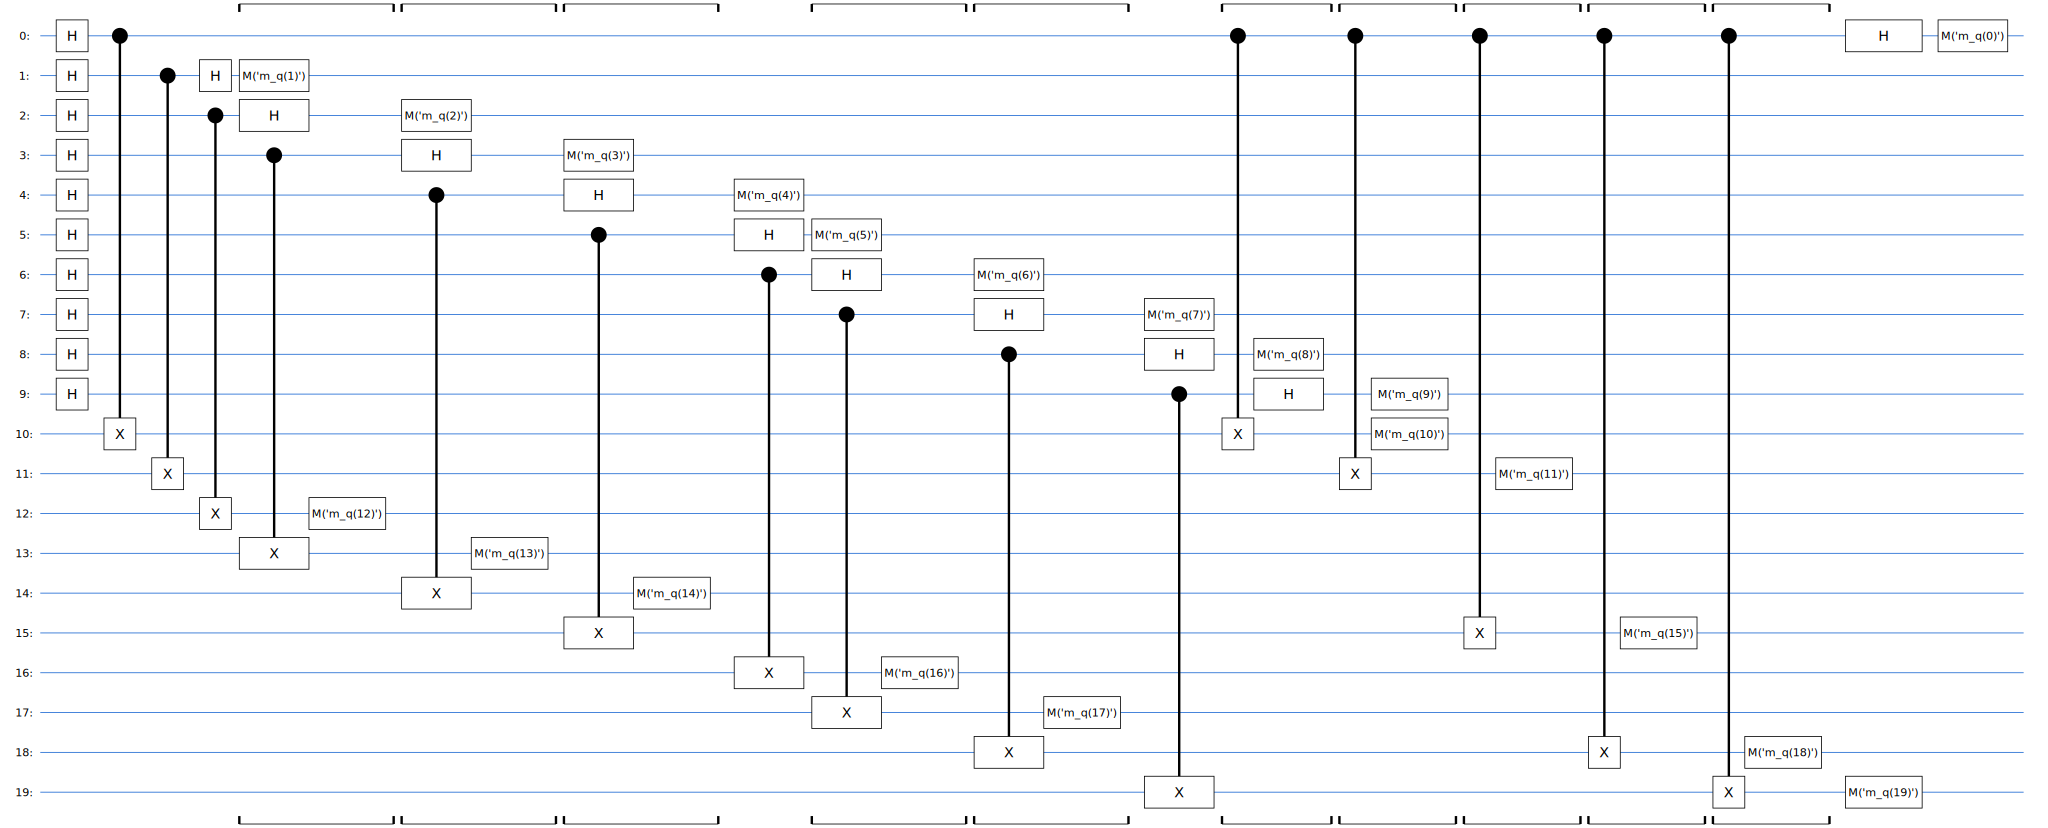


Simulation Results:
m_q(0)=10010111010001010111011100100111001100111010011111001110110101010011110101001110011111001011101110011111111101011101110100100000111100100010110101101110010010010100100101100111011001101111000010100010
m_q(1)=10111001101111000000010001101000000111110110101101110000101100001010001011101000101101100001110110111110110010100111000010001000010011100000000111010101001010110100110001100010000100000011010010011100
m_q(10)=00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
m_q(11)=11001100100111010000001101110100001111001100011110001111110110101010110110000011011001010110110100000010101000011110011110111101110111111101100111010111000111000110101111011111001010011101001111100011
m_q(12)=10011000000010100101111100110110111011010000001010111110111111110010011100000110001100000010000000110111001110111000100110110001000100010

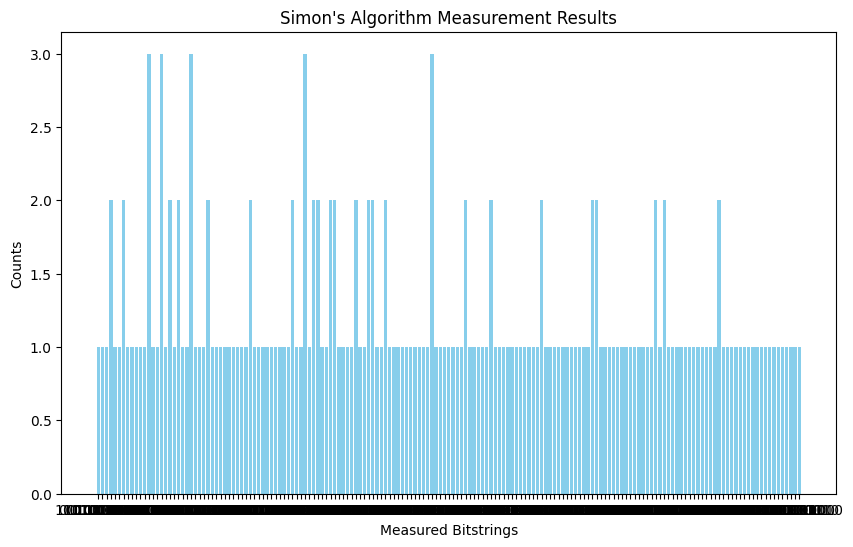


Collected y-vectors:
y = 1111001100, y • s = 0
y = 0011111101, y • s = 0
y = 0110111011, y • s = 0
y = 1101000100, y • s = 0
y = 0111001101, y • s = 0
y = 1000001001, y • s = 0
y = 1000000010, y • s = 0
y = 1101001000, y • s = 0
y = 0110100001, y • s = 0

Extracted Secret String s: 1001110011
Mismatch! The extracted secret string does not match the original.


In [19]:
def main():
    # Example Test
    test_simon(n=5, shots=200)

if __name__ == "__main__":
    main()
